## Importing Modules and Libraries

In [1]:
from functions_py import *
import scipy.ndimage as ndimage
import skimage.measure as sk
import matplotlib.pyplot as plt

## Open Image 

In [2]:
hdu_list=fits.open('/share/storage2/connie/DAna/SkpImages/calibImages/118/cal_11_2_v2_proc_runID118_skp_NSAMP400_EXP0_img1_1063.fits')
hdu_list.info()

Filename: /share/storage2/connie/DAna/SkpImages/calibImages/118/cal_11_2_v2_proc_runID118_skp_NSAMP400_EXP0_img1_1063.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     173   (420, 1022)   float32   


In [3]:
data=hdu_list[0].data
data.shape

(1022, 420)

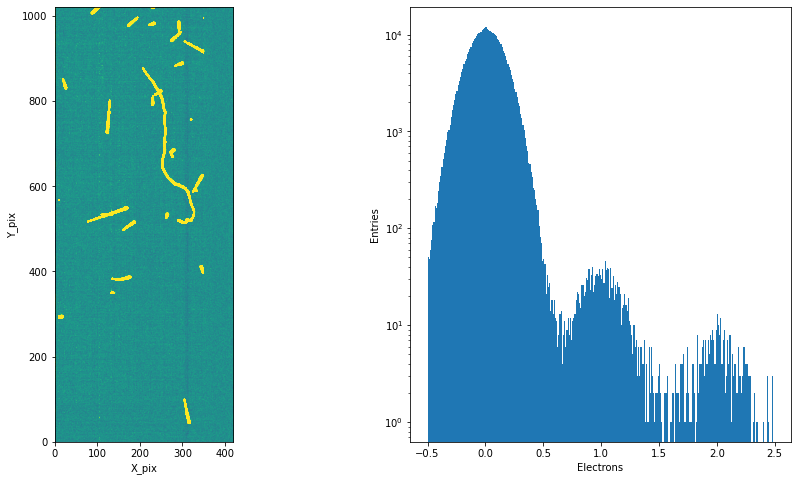

In [4]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(data,vmin=-1,vmax=1,origin='lower')
plt.ylabel('Y_pix')
plt.xlabel('X_pix')

plt.subplot(122)
plt.hist(data.flatten(),bins=np.arange(-0.5,2.5,0.01))
plt.yscale('log')
plt.ylabel('Entries')
plt.xlabel('Electrons')
plt.show()

##  Cluster the events

In [5]:
threshold=4 #electrons

(label,N_features)=ndimage.label(data>threshold,structure=[[1,1,1],[1,1,1],[1,1,1]])

In [6]:
print('N_features type:',type(N_features), '=', N_features)
print(N_features, 'events were reconstructed'+'\n')
print('label type:',type(label))

N_features type: <class 'int'> = 25
25 events were reconstructed

label type: <class 'numpy.ndarray'>


In [7]:
label=ndimage.label(data>threshold,structure=[[1,1,1],[1,1,1],[1,1,1]])[0] 

#Each reconstructed event will have their pixels labeled with a integer number in sequence

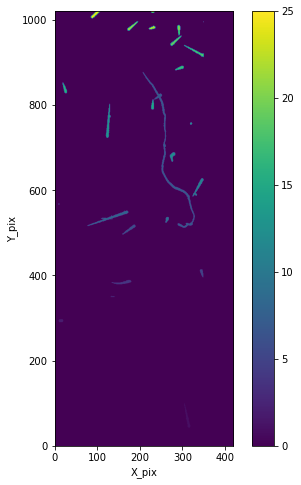

In [8]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(label,origin='lower')
plt.colorbar()
plt.ylabel('Y_pix')
plt.xlabel('X_pix')
plt.show()

Showing each event reconstructed

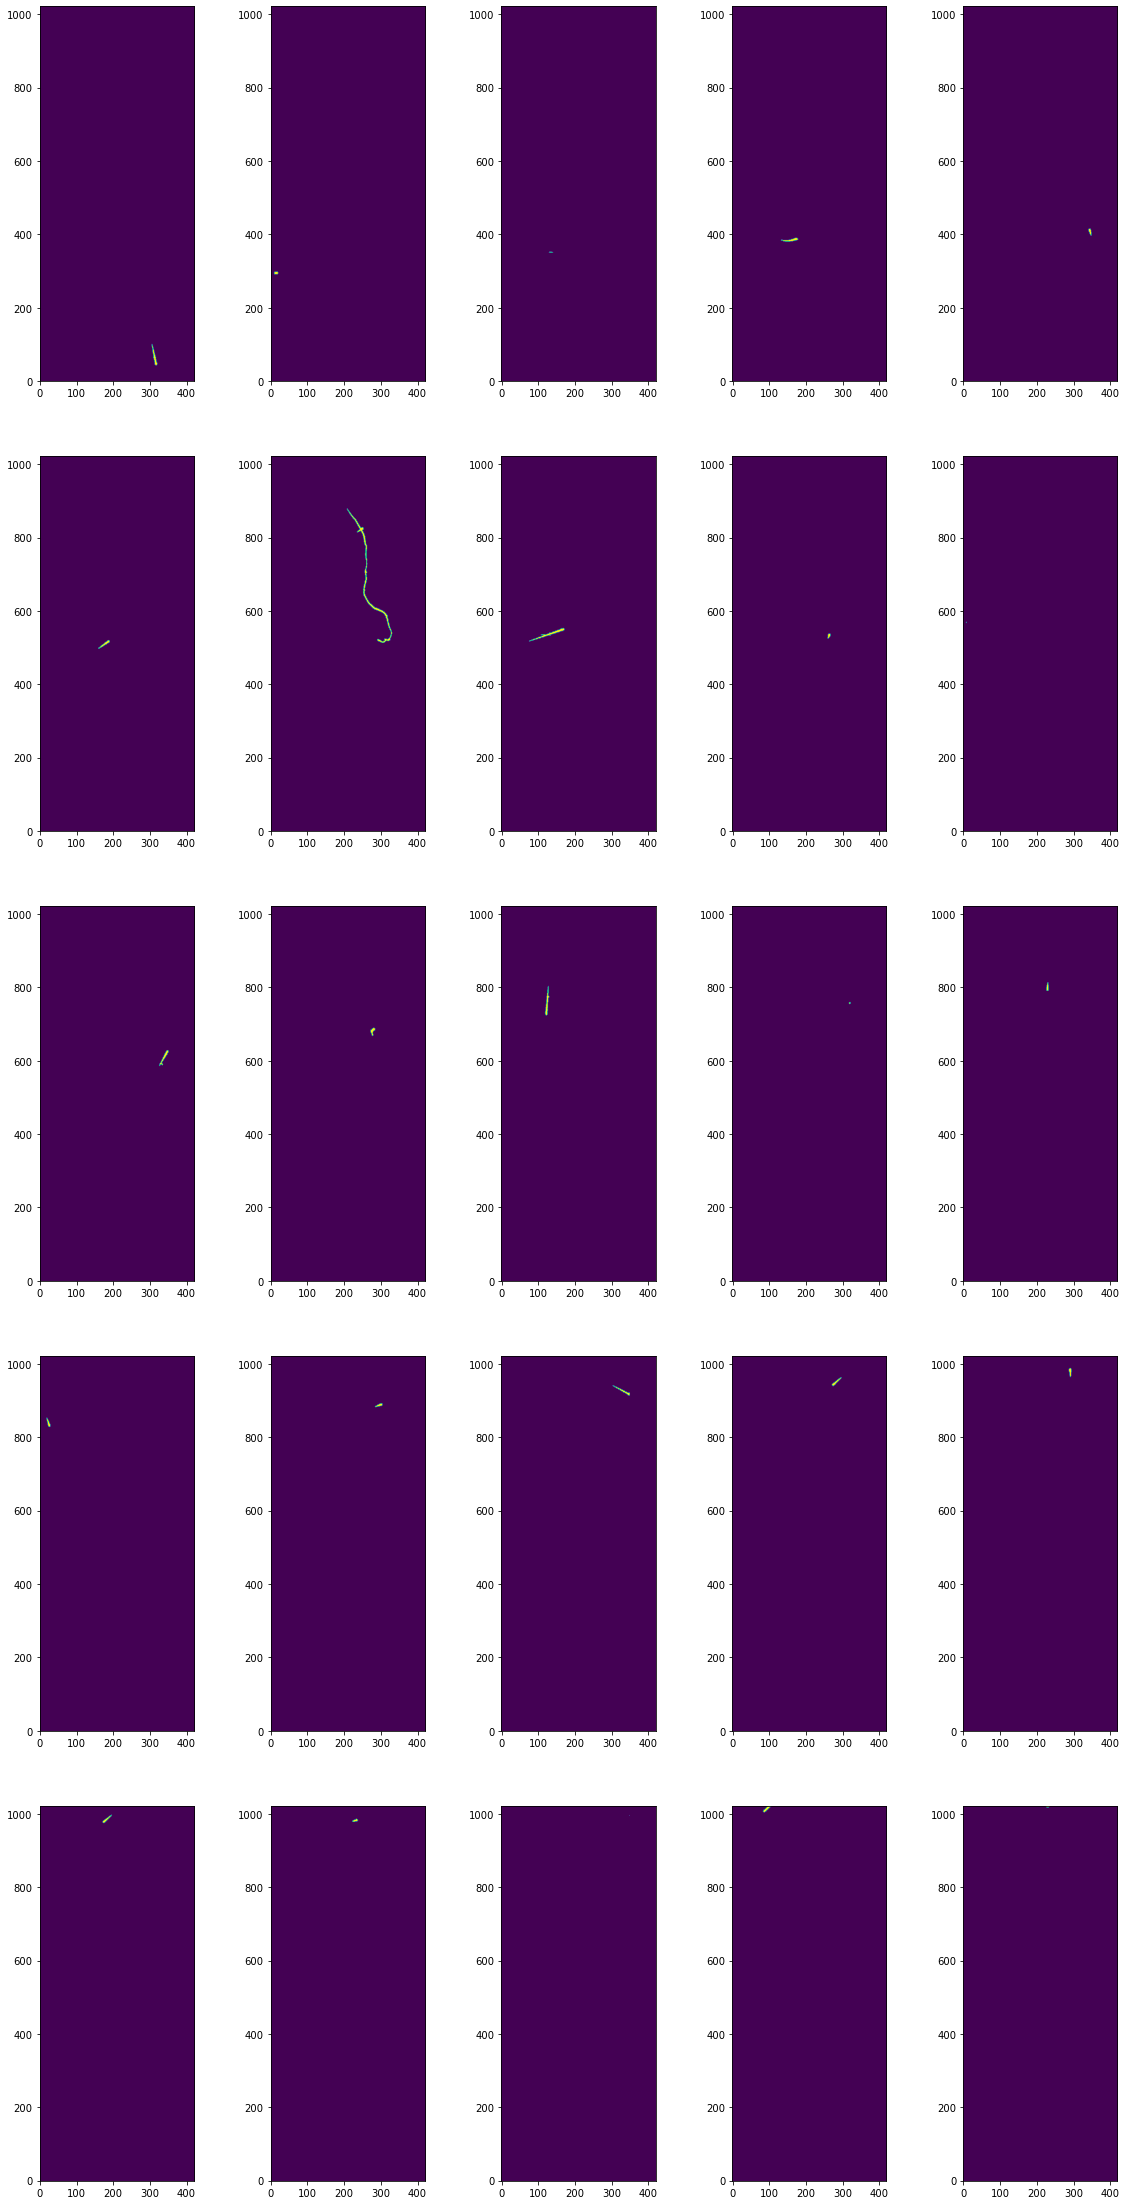

In [9]:
plt.figure(figsize=(20,40))
for index in range(1,26):
    plt.subplot(5,5,index)
    plt.imshow(label==index,origin='lower')
plt.show()

## Scikit-Image regionprops

In [10]:
hdu_list=fits.open('/share/storage2/connie/DAna/SkpImages/calibImages/118/cal_10_0_v2_proc_runID118_skp_NSAMP400_EXP0_img2_1069.fits')
hdu_list.info()

Filename: /share/storage2/connie/DAna/SkpImages/calibImages/118/cal_10_0_v2_proc_runID118_skp_NSAMP400_EXP0_img2_1069.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     175   (420, 1022)   float32   


Text(0.5, 0, 'X_pix')

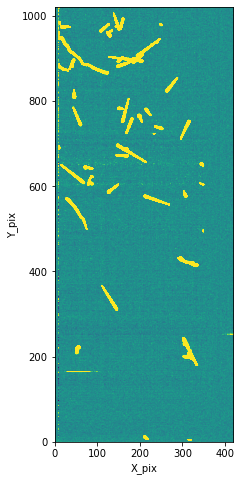

In [11]:
data=hdu_list[0].data
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(data,vmin=-1,vmax=1,origin='lower')
plt.ylabel('Y_pix')
plt.xlabel('X_pix')


In [12]:
(label,N_features)=ndimage.label(data>threshold,structure=[[1,1,1],[1,1,1],[1,1,1]])
N_features

104

In [13]:
def sum_intensity(region, intensities):
    return np.sum(intensities[region])

rps=sk.regionprops(label,intensity_image=data,cache=False, extra_properties=[sum_intensity])

# FOR EACH REGION IN THE REGIONS RECONSTRUCTED
areas=[r.area for r in rps] 
energy=[r.sum_intensity for r in rps]
centr=[r.weighted_centroid for r in rps]  # (ybary,xbary)
ecce=[r.eccentricity for r in rps]
bbox=[r.bbox for r in rps] # (ymin,xmin,ymax,xmax)

dic_props={"areas":areas,"energy":energy,'barycenter':centr, "eccenticity":ecce, "bbox": bbox}

In [14]:
df=pd.DataFrame.from_dict(dic_props) # DataFrame from dict to visualize
df.index = np.arange(1, N_features+1)
df.head(5)

,areas,energy,barycenter,eccenticity,bbox
1,8,16310.177734,"(5.0, 315.6815513399641)",1.000000,"(5, 312, 6, 320)"
2,67,38139.605469,"(9.110492319054936, 213.04970410717678)",0.862863,"(6, 207, 15, 219)"
3,1,4.014600,"(32.0, 8.0)",0.000000,"(32, 8, 33, 9)"
4,1,4.130868,"(68.0, 8.0)",0.000000,"(68, 8, 69, 9)"
5,44,733.681335,"(165.0, 51.76222162313515)",1.000000,"(165, 30, 166, 74)"


In [16]:
df[(df['eccenticity']==1) &( df['areas']>2)]

,areas,energy,barycenter,eccenticity,bbox
1,8,16310.177734,"(5.0, 315.6815513399641)",1.0,"(5, 312, 6, 320)"
5,44,733.681335,"(165.0, 51.76222162313515)",1.0,"(165, 30, 166, 74)"
58,5,9570.729492,"(724.0, 232.1516311369491)",1.0,"(724, 230, 725, 235)"


In [17]:
pos_sre_index=df[(df['eccenticity']==1) &( df['areas']>2)].index.tolist()
pos_sre_index

[1, 5, 58]

In [18]:
SRE_events=np.zeros_like(label) # Image with only the selected reconstructed events
for ind in pos_sre_index:
    [x,y]=np.where(label==ind)
    for i in range(len(x)):
        SRE_events[x[i],y[i]]=1 

Text(0.5, 0, 'X_pix')

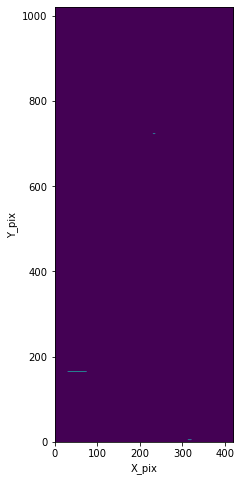

In [19]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(SRE_events,vmin=0,vmax=1,origin='lower')
plt.ylabel('Y_pix')
plt.xlabel('X_pix')


In [20]:
import skimage
skimage.__version__

'0.18.1'

In [21]:
hdu_list=fits.open('/share/storage2/connie/DAna/SkpImages/calibImages/118/cal_11_2_v2_proc_runID118_skp_NSAMP400_EXP0_img1_1063.fits')
data=hdu_list[0].data

threshold = 4 # electrons

label=ndimage.label(data>threshold,structure=[[1,1,1],[1,1,1],[1,1,1]])[0] 
rps=sk.regionprops(label,intensity_image=data,cache=False, extra_properties=[sum_intensity])

slices=[r.slice for r in rps]

In [22]:
from matplotlib import colors

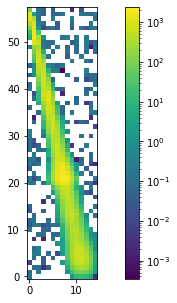

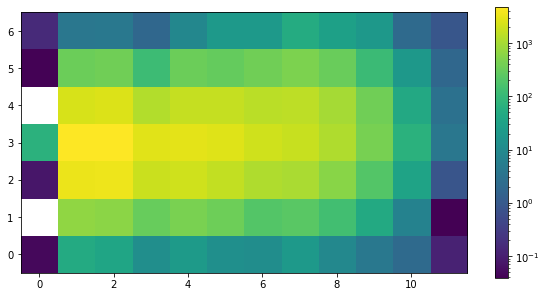

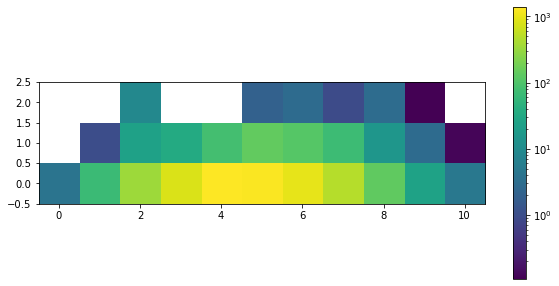

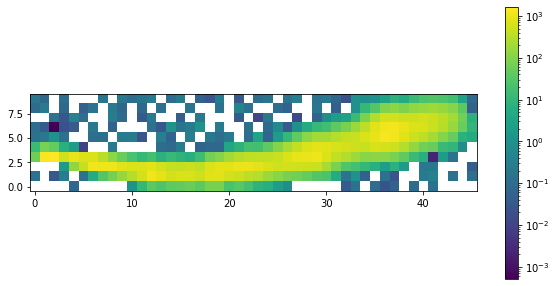

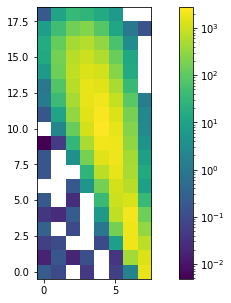

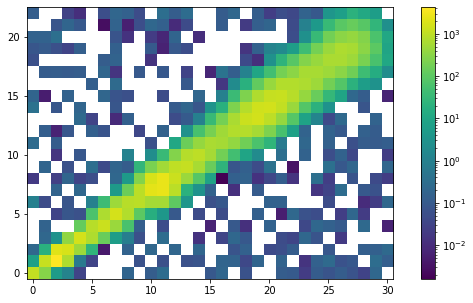

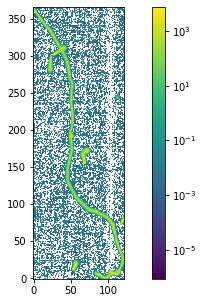

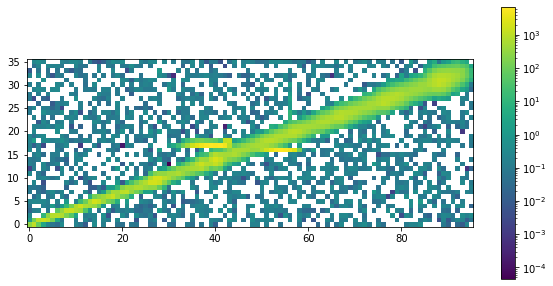

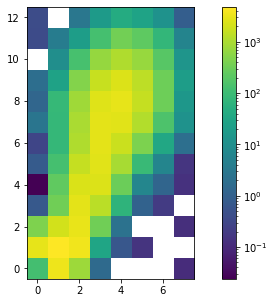

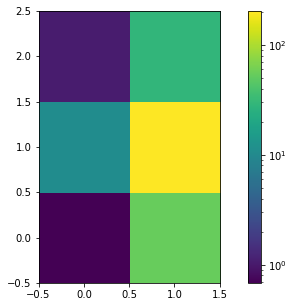

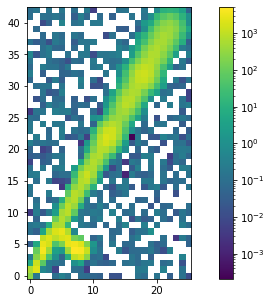

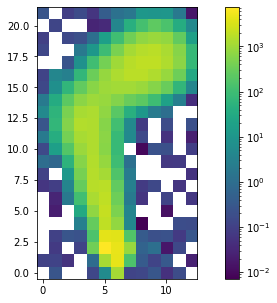

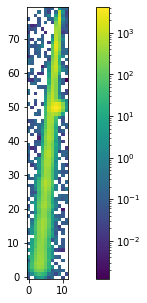

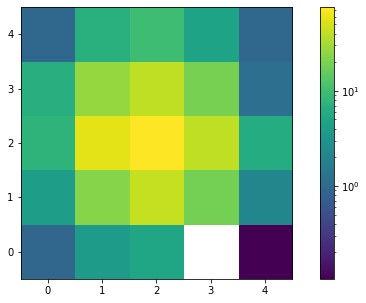

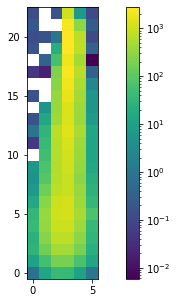

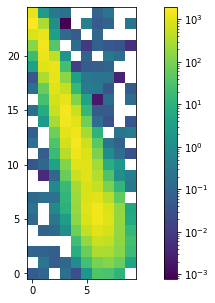

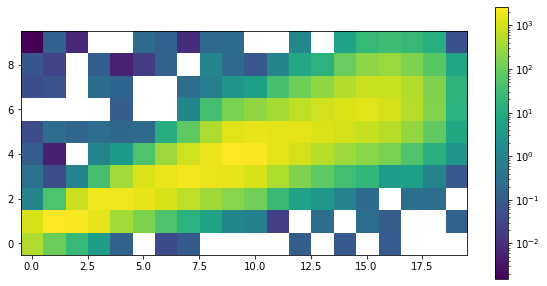

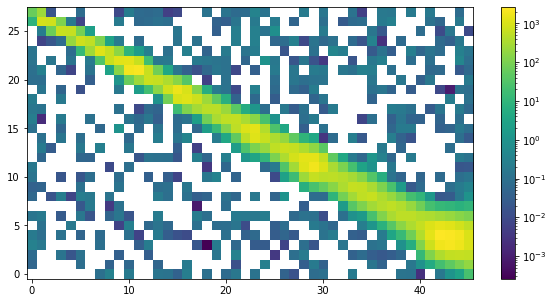

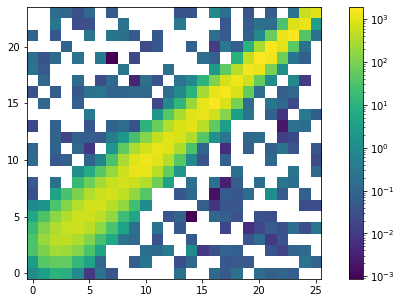

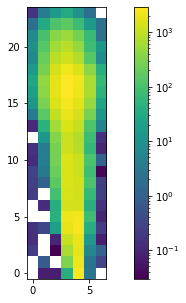

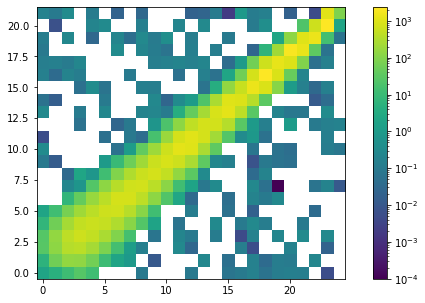

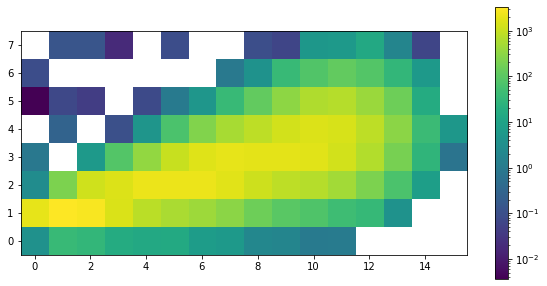

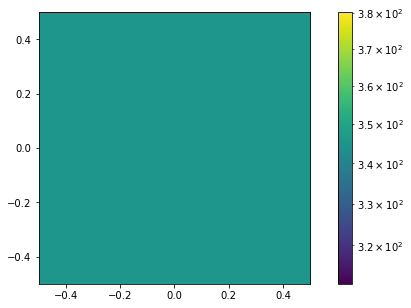

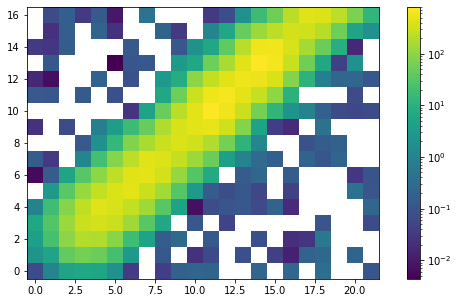

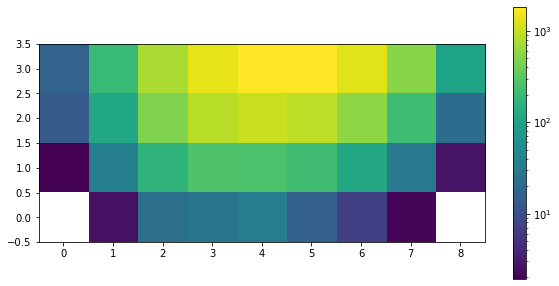

In [23]:
for slic in slices:
    plt.figure(figsize=(10,5))
    plt.imshow(data[slic],norm=colors.LogNorm(),origin='lower')
    plt.colorbar()
    plt.show()